# Deep Learning Course Project - Gesture Recognition


* Anusha Oorugonda
* Himabindu Srirangam

#### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

Each gesture corresponds to a specific command.
* Thumbs up:  Increase the volume
* Thumbs down: Decrease the volume
* Left swipe: 'Jump' backwards 10 seconds
* Right swipe: 'Jump' forward 10 seconds  
* Stop: Pause the movie

Each video is a sequence of 30 frames (or images).

#### Objectives:
* **Generator**: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

* **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

* **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.


In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imresize
from imageio import imread
import datetime
import os

import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
print(tf.__version__)
tf.set_random_seed(30)

Using TensorFlow backend.


1.10.0


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
!gdown https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL

Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
To: /mnt/disks/user/project/PROJECT/Project_data.zip
1.71GB [00:22, 75.9MB/s]


In [5]:
!unzip './Project_data.zip'

Archive:  ./Project_data.zip
   creating: Project_data/
   creating: Project_data/train/
  inflating: Project_data/train.csv  
   creating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00014.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00016.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00018.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00020.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00022.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00024.png  
  inflating: P

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

### Plot the training/validation accuracies/losses

In [4]:
# function to plot the training/validation accuracies/losses.
import cv2
import matplotlib.pyplot as plt
% matplotlib inline
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## **Sample Model**

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
import keras

In [14]:
#write your model here
#model A
model = Sequential()
model.add(Conv3D(8, kernel_size=(3,3,3),
                   input_shape=(30,120,120,3),
                   padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flattern Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
history_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 107s 2s/step - loss: 5.8925 - categorical_accuracy: 0.2493 - val_loss: 2.9995 - val_categorical_accuracy: 0.3100

Epoch 00001: saving model to model_init_2021-01-2806_24_34.280377/model-00001-5.92565-0.25189-2.99950-0.31000.h5
Epoch 2/10
67/67 [==============================] - 31s 469ms/step - loss: 3.0862 - categorical_accuracy: 0.3085 - val_loss: 4.8617 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2021-01-2806_24_34.280377/model-00002-3.08616-0.30846-4.86168-0.18000.h5
Epoch 3/10
67/67 [==============================] - 33s 490ms/step - loss: 2.4952 - categorical_accuracy: 0.2388 - val_loss: 1.6782 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_2021-01-2806_24_34.280377/model-00003-2.49524-0.23881-1.67815-0.33000.h5
Epoch 4/10
67/67 [==============================] - 3

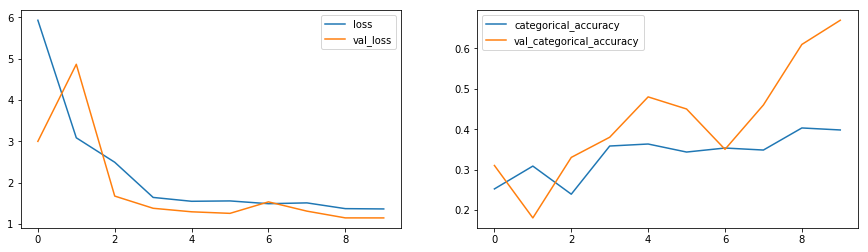

In [20]:
plot(history_model)

In [9]:
project_folder = "Project_data"

In [10]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [12]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

## **Sample Cropping**

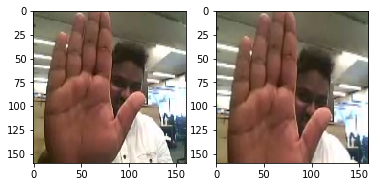

In [13]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])

**Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size**

In [25]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 89s 4s/step - loss: 1.7953 - categorical_accuracy: 0.3412 - val_loss: 1.3678 - val_categorical_accuracy: 0.4700

Epoch 00001: val_loss improved from inf to 1.36782, saving model to model_init_2021-01-2806_31_47.100344/model-00001-1.76037-0.35445-1.36782-0.47000.h5
Epoch 2/2
23/23 [==============================] - 78s 3s/step - loss: 1.2619 - categorical_accuracy: 0.5075 - val_loss: 1.8148 - val_categorical_accuracy: 0.4200

Epoch 00002: val_loss did not improve from 1.36782


In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - 85s 2s/step - loss: 1.6294 - categorical_accuracy: 0.4253 - val_loss: 1.7859 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 1.78595, saving model to model_init_2021-01-2806_34_41.292263/model-00001-1.61266-0.41931-1.78595-0.46000.h5
Epoch 2/2
34/34 [==============================] - 77s 2s/step - loss: 1.1942 - categorical_accuracy: 0.5180 - val_loss: 1.1686 - val_categorical_accuracy: 0.6200

Epoch 00002: val_loss improved from 1.78595 to 1.16859, saving model to model_init_2021-01-2806_34_41.292263/model-00002-1.20224-0.51433-1.16859-0.62000.h5


In [27]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 101s 2s/step - loss: 1.5510 - categorical_accuracy: 0.4224 - val_loss: 1.3934 - val_categorical_accuracy: 0.4900

Epoch 00001: val_loss improved from inf to 1.39336, saving model to model_init_2021-01-2806_37_30.512704/model-00001-1.53177-0.42986-1.39336-0.49000.h5
Epoch 2/2
45/45 [==============================] - 86s 2s/step - loss: 1.1622 - categorical_accuracy: 0.5408 - val_loss: 1.1130 - val_categorical_accuracy: 0.5800

Epoch 00002: val_loss improved from 1.39336 to 1.11305, saving model to model_init_2021-01-2806_37_30.512704/model-00002-1.15345-0.54449-1.11305-0.58000.h5


In [28]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - 57s 2s/step - loss: 1.6066 - categorical_accuracy: 0.4190 - val_loss: 1.3897 - val_categorical_accuracy: 0.5200

Epoch 00001: val_loss improved from inf to 1.38969, saving model to model_init_2021-01-2806_40_46.607731/model-00001-1.58269-0.42232-1.38969-0.52000.h5
Epoch 2/2
23/23 [==============================] - 45s 2s/step - loss: 1.0887 - categorical_accuracy: 0.5578 - val_loss: 1.2527 - val_categorical_accuracy: 0.5100

Epoch 00002: val_loss improved from 1.38969 to 1.25271, saving model to model_init_2021-01-2806_40_46.607731/model-00002-1.09512-0.55354-1.25271-0.51000.h5




*   From the above experiments image resolutions and number of frames in sequence have more impact on training time than batch size.
*   We can consider the Batch Size around 15-40
*   We will change the resoulution 160X160, 120X120 according the model performance



## **Model-1 Base Model, Batch size = 40, No. of Epochs=15**

In [29]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_22 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 10, 80, 80, 32)    128       
__________

In [31]:
print("Total Params:", conv_3d1_model.count_params())
history_model_1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 76s 4s/step - loss: 1.5110 - categorical_accuracy: 0.4404 - val_loss: 1.7797 - val_categorical_accuracy: 0.4800

Epoch 00001: val_loss improved from inf to 1.77967, saving model to model_init_2021-01-2806_42_36.725523/model-00001-1.51930-0.43741-1.77967-0.48000.h5
Epoch 2/15
17/17 [==============================] - 53s 3s/step - loss: 1.0256 - categorical_accuracy: 0.5677 - val_loss: 1.7097 - val_categorical_accuracy: 0.4500

Epoch 00002: val_loss improved from 1.77967 to 1.70972, saving model to model_init_2021-01-2806_42_36.725523/model-00002-1.03202-0.56561-1.70972-0.45000.h5
Epoch 3/15
17/17 [==============================] - 60s 4s/step - loss: 0.7340 - categorical_accuracy: 0.7435 - val_loss: 1.0547 - val_categorical_accuracy: 0.6200

Epoch 00003: val_loss improved from 1.70972 to 1.05473, saving model to model_init_2021-01-2806_42_36.725523/model-00003-0.73229-0.74359-1.05473-0.62000.h5
Epoch 4/15
17/17 [=

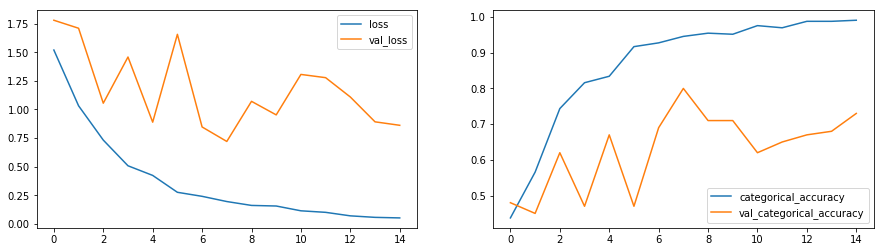

In [32]:
plot(history_model_1)

**Model is overfitting, we need to do Data augumentation**

## **Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution**

In [33]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 10, 80, 80, 32)    128       
__________

In [34]:
print("Total Params:", conv_3d2_model.count_params())
history_model_2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 130s 4s/step - loss: 1.8665 - categorical_accuracy: 0.4043 - val_loss: 1.5293 - val_categorical_accuracy: 0.5500

Epoch 00001: val_loss improved from inf to 1.52932, saving model to model_init_2021-01-2806_57_50.751811/model-00001-1.86978-0.40196-1.52932-0.55000.h5
Epoch 2/25
34/34 [==============================] - 120s 4s/step - loss: 1.5317 - categorical_accuracy: 0.4654 - val_loss: 1.2889 - val_categorical_accuracy: 0.5900

Epoch 00002: val_loss improved from 1.52932 to 1.28892, saving model to model_init_2021-01-2806_57_50.751811/model-00002-1.53072-0.46456-1.28892-0.59000.h5
Epoch 3/25
34/34 [==============================] - 125s 4s/step - loss: 1.1074 - categorical_accuracy: 0.6004 - val_loss: 1.7230 - val_categorical_accuracy: 0.4800

Epoch 00003: val_loss did not improve from 1.28892
Epoch 4/25
34/34 [==============================] - 125s 4s/step - loss: 1.0205 - categorical_accuracy: 0.6350 - val_loss

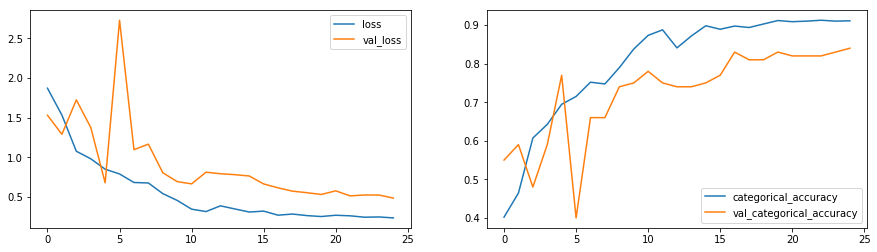

In [35]:
plot(history_model_2)

**Model is not overfitting and we get a best validation accuracy of 82% and training accuracy of 91%.**


**Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002**

## **Model 3 - Reduce filter size to (2,2,2) and image resolution to 120 x 120**

In [36]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_30 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 8, 60, 60, 32)     128       
__________

In [38]:
print("Total Params:", conv_3d3_model.count_params())
history_model_3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 90s 4s/step - loss: 2.2332 - categorical_accuracy: 0.3005 - val_loss: 1.2927 - val_categorical_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.29275, saving model to model_init_2021-01-2807_49_04.828721/model-00001-2.16471-0.31222-1.29275-0.50000.h5
Epoch 2/30
23/23 [==============================] - 76s 3s/step - loss: 1.5095 - categorical_accuracy: 0.4855 - val_loss: 0.9426 - val_categorical_accuracy: 0.6200

Epoch 00002: val_loss improved from 1.29275 to 0.94256, saving model to model_init_2021-01-2807_49_04.828721/model-00002-1.49993-0.48492-0.94256-0.62000.h5
Epoch 3/30
23/23 [==============================] - 83s 4s/step - loss: 1.3033 - categorical_accuracy: 0.5308 - val_loss: 0.9210 - val_categorical_accuracy: 0.6900

Epoch 00003: val_loss improved from 0.94256 to 0.92101, saving model to model_init_2021-01-2807_49_04.828721/model-00003-1.28943-0.53846-0.92101-0.69000.h5
Epoch 4/30
23/23 [=

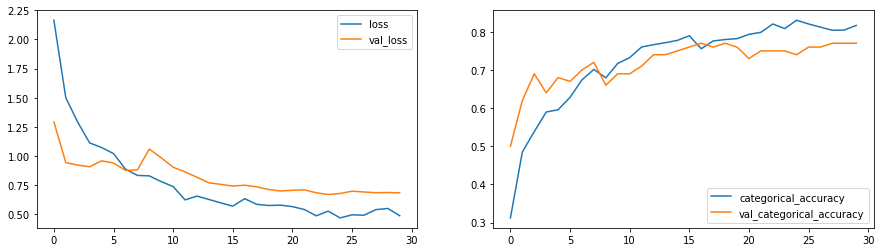

In [39]:
plot(history_model_3)

**Model has a best validation accuracy of 75% and training accuracy of 80% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers**

## **Model 4 - Adding more layers**

In [40]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_34 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [42]:
print("Total Params:", conv_3d4_model.count_params())
history_model_4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 114s 3s/step - loss: 2.0451 - categorical_accuracy: 0.3639 - val_loss: 8.1144 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 8.11444, saving model to model_init_2021-01-2808_30_00.225002/model-00001-2.05461-0.36048-8.11444-0.23000.h5
Epoch 2/30
34/34 [==============================] - 93s 3s/step - loss: 1.6254 - categorical_accuracy: 0.4356 - val_loss: 6.9310 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss improved from 8.11444 to 6.93097, saving model to model_init_2021-01-2808_30_00.225002/model-00002-1.62723-0.43816-6.93097-0.26000.h5
Epoch 3/30
34/34 [==============================] - 93s 3s/step - loss: 1.4084 - categorical_accuracy: 0.5199 - val_loss: 2.5859 - val_categorical_accuracy: 0.5000

Epoch 00003: val_loss improved from 6.93097 to 2.58593, saving model to model_init_2021-01-2808_30_00.225002/model-00003-1.38685-0.52036-2.58593-0.50000.h5
Epoch 4/30
34/34 [

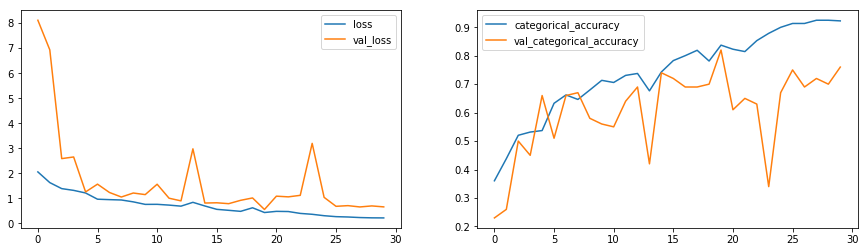

In [43]:
plot(history_model_4)

**With more layers we dont see much performance improvement. We get a best validation accuracy of 82% . Let's try adding dropouts at the convolution layers**

## **Model-5 - Adding dropout at convolution layers**

In [44]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [45]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_41 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_42 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [46]:
print("Total Params:", conv_3d5_model.count_params())
history_model_5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - 104s 3s/step - loss: 1.8677 - categorical_accuracy: 0.3565 - val_loss: 2.9293 - val_categorical_accuracy: 0.4800

Epoch 00001: val_loss improved from inf to 2.92932, saving model to model_init_2021-01-2809_17_00.514146/model-00001-1.83720-0.36124-2.92932-0.48000.h5
Epoch 2/22
34/34 [==============================] - 93s 3s/step - loss: 1.2436 - categorical_accuracy: 0.5269 - val_loss: 1.4402 - val_categorical_accuracy: 0.5400

Epoch 00002: val_loss improved from 2.92932 to 1.44017, saving model to model_init_2021-01-2809_17_00.514146/model-00002-1.26744-0.51508-1.44017-0.54000.h5
Epoch 3/22
34/34 [==============================] - 93s 3s/step - loss: 1.1443 - categorical_accuracy: 0.5732 - val_loss: 0.8368 - val_categorical_accuracy: 0.6500

Epoch 00003: val_loss improved from 1.44017 to 0.83684, saving model to model_init_2021-01-2809_17_00.514146/model-00003-1.16829-0.56259-0.83684-0.65000.h5
Epoch 4/22
34/34 [

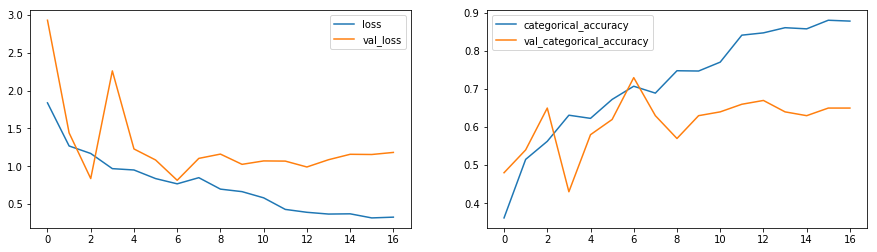

In [47]:
plot(history_model_5)

**Adding dropouts has further reduced validation accuracy as its not to learn generalizable features**


**All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance**

## **Model 6 - reducing the number of parameters**

In [48]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [49]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_49 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_50 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 8, 50, 50, 32)     128       
__________

In [50]:
print("Total Params:", conv_3d6_model.count_params())
history_model_6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 83s 2s/step - loss: 1.9172 - categorical_accuracy: 0.3554 - val_loss: 1.3110 - val_categorical_accuracy: 0.4400

Epoch 00001: val_loss improved from inf to 1.31104, saving model to model_init_2021-01-2809_43_45.141637/model-00001-1.89153-0.35596-1.31104-0.44000.h5
Epoch 2/30
34/34 [==============================] - 70s 2s/step - loss: 1.3410 - categorical_accuracy: 0.5125 - val_loss: 1.1848 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 1.31104 to 1.18480, saving model to model_init_2021-01-2809_43_45.141637/model-00002-1.28542-0.52112-1.18480-0.55000.h5
Epoch 3/30
34/34 [==============================] - 78s 2s/step - loss: 1.0449 - categorical_accuracy: 0.5843 - val_loss: 1.0596 - val_categorical_accuracy: 0.6200

Epoch 00003: val_loss improved from 1.18480 to 1.05963, saving model to model_init_2021-01-2809_43_45.141637/model-00003-1.04714-0.59050-1.05963-0.62000.h5
Epoch 4/30
34/34 [==

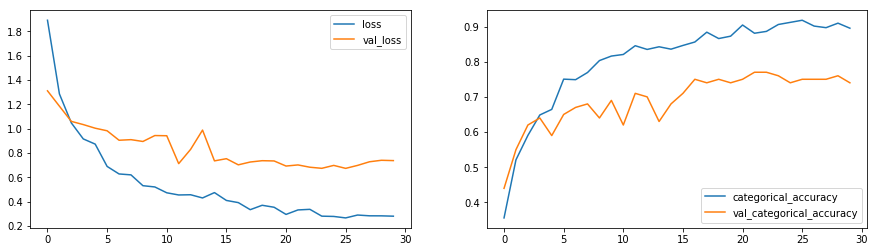

In [51]:
plot(history_model_6)

**For the above low memory foot print model the best validation accuracy of 76%**

## **Model 7 - reducing the number of parameters**

In [53]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [54]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_54 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 8, 60, 60, 32)     128       
__________

In [55]:
print("Total Params:", conv_3d7_model.count_params())
history_model_7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 87s 3s/step - loss: 1.9453 - categorical_accuracy: 0.3230 - val_loss: 1.2828 - val_categorical_accuracy: 0.4900

Epoch 00001: val_loss improved from inf to 1.28278, saving model to model_init_2021-01-2810_22_09.429570/model-00001-1.95999-0.31448-1.28278-0.49000.h5
Epoch 2/25
34/34 [==============================] - 72s 2s/step - loss: 1.3461 - categorical_accuracy: 0.4676 - val_loss: 1.0241 - val_categorical_accuracy: 0.6300

Epoch 00002: val_loss improved from 1.28278 to 1.02406, saving model to model_init_2021-01-2810_22_09.429570/model-00002-1.33804-0.47511-1.02406-0.63000.h5
Epoch 3/25
34/34 [==============================] - 79s 2s/step - loss: 1.1057 - categorical_accuracy: 0.5614 - val_loss: 1.0494 - val_categorical_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 1.02406
Epoch 4/25
34/34 [==============================] - 79s 2s/step - loss: 0.9821 - categorical_accuracy: 0.6269 - val_loss: 1.0

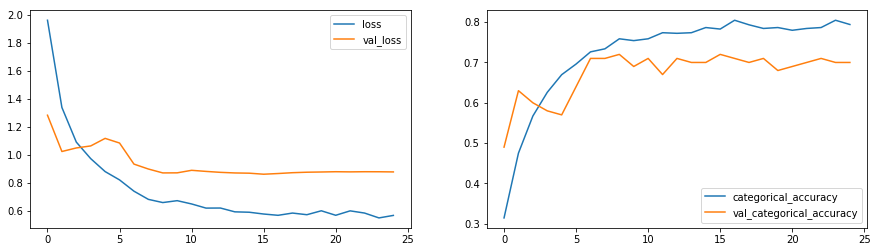

In [56]:
plot(history_model_7)

**For the above low memory foot print model the best validation accuracy of 72%**

## **Model 8 - reducing the number of parameters**

In [57]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [58]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_57 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_58 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 8, 60, 60, 16)     64        
__________

In [59]:
print("Total Params:", conv_3d8_model.count_params())
history_model_8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 86s 3s/step - loss: 2.0768 - categorical_accuracy: 0.2686 - val_loss: 1.4710 - val_categorical_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 1.47098, saving model to model_init_2021-01-2810_56_06.278400/model-00001-2.08353-0.26697-1.47098-0.41000.h5
Epoch 2/30
34/34 [==============================] - 71s 2s/step - loss: 1.4699 - categorical_accuracy: 0.4514 - val_loss: 1.1774 - val_categorical_accuracy: 0.5400

Epoch 00002: val_loss improved from 1.47098 to 1.17744, saving model to model_init_2021-01-2810_56_06.278400/model-00002-1.45895-0.45852-1.17744-0.54000.h5
Epoch 3/30
34/34 [==============================] - 81s 2s/step - loss: 1.2684 - categorical_accuracy: 0.5099 - val_loss: 1.0149 - val_categorical_accuracy: 0.6500

Epoch 00003: val_loss improved from 1.17744 to 1.01487, saving model to model_init_2021-01-2810_56_06.278400/model-00003-1.26112-0.51433-1.01487-0.65000.h5
Epoch 4/30
34/34 [==

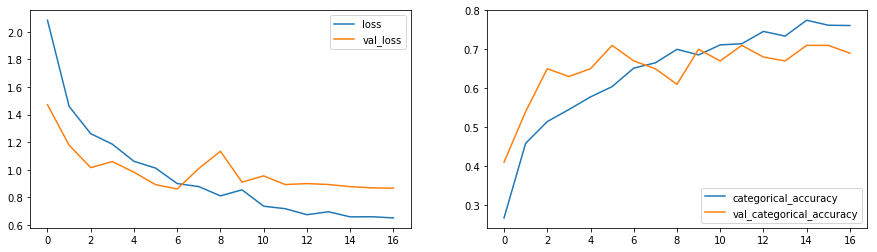

In [60]:
plot(history_model_8)

**For the above low memory foot print model the best validation accuracy of 67%**

## **Model 9 - CNN- LSTM Model**

In [61]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [65]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [66]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model_9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 99s 3s/step - loss: 1.4027 - categorical_accuracy: 0.3797 - val_loss: 1.2457 - val_categorical_accuracy: 0.5200

Epoch 00001: val_loss improved from inf to 1.24574, saving model to model_init_2021-01-2811_23_54.529772/model-00001-1.40140-0.38914-1.24574-0.52000.h5
Epoch 2/20
34/34 [==============================] - 82s 2s/step - loss: 1.0800 - categorical_accuracy: 0.5390 - val_loss: 0.9564 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss improved from 1.24574 to 0.95641, saving model to model_init_2021-01-2811_23_54.529772/model-00002-1.09142-0.53167-0.95641-0.60000.h5
Epoch 3/20
34/34 [==============================] - 90s 3s/step - loss: 0.9144 - categorical_accuracy: 0.6317 - val_loss: 0.8790 - val_categorical_accuracy: 0.6800

Epoch 00003: val_loss improved from 0.95641 to 0.87899, saving model to model_init_2021-01-2811_23_54.529772/model-00003-0.92225-0.62670-0.87899-0.68000.h5
Epoch 4/20
34/34 [=

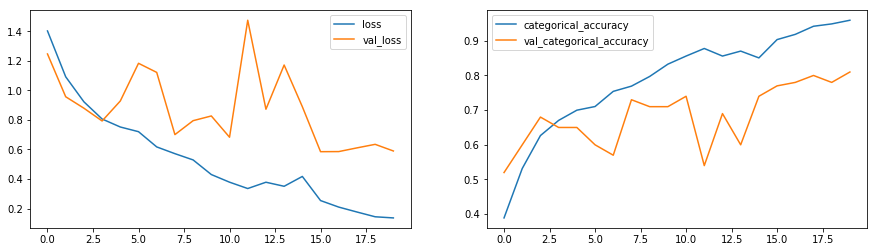

In [67]:
plot(history_model_9)

**For CNN - LSTM model we get a best validation accuracy of 77%**

**As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again**

## **More Augmentation**

In [14]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## **Model 10 - More Agumentation - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2**

In [9]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 80, 80, 32)    128       
__________

In [11]:
print("Total Params:", conv_3d10_model.count_params())
history_model_10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 275s 8s/step - loss: 1.9537 - categorical_accuracy: 0.3797 - val_loss: 1.6269 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2021-01-2812_46_12.250426/model-00001-1.94806-0.38084-1.62692-0.47000.h5
Epoch 2/30
34/34 [==============================] - 130s 4s/step - loss: 1.3152 - categorical_accuracy: 0.5383 - val_loss: 0.8346 - val_categorical_accuracy: 0.7000

Epoch 00002: saving model to model_init_2021-01-2812_46_12.250426/model-00002-1.31895-0.53922-0.83463-0.70000.h5
Epoch 3/30
34/34 [==============================] - 130s 4s/step - loss: 1.1612 - categorical_accuracy: 0.5927 - val_loss: 0.9188 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2021-01-2812_46_12.250426/model-00003-1.15982-0.59502-0.91875-0.65000.h5
Epoch 4/30
34/34 [==============================] - 127s 4s/step - loss: 1.0168 - categorical_accuracy: 0.6358 - val_loss: 0.9818 - val_categ

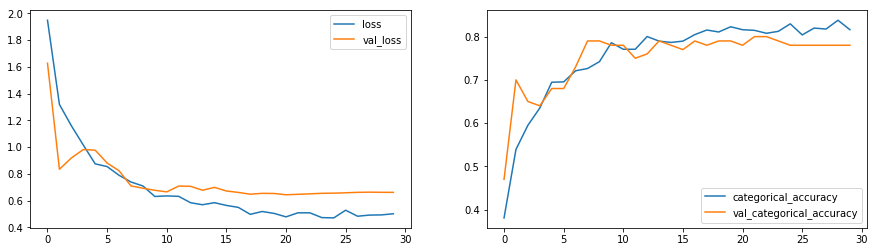

In [12]:
plot(history_model_10)

## **Model 11 - More Agumentation (2,2,2) Filter & 120x120 Image resolution - similar to Model 3**

In [20]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

In [22]:
print("Total Params:", conv_3d11_model.count_params())
history_model_11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 132s 6s/step - loss: 2.1791 - categorical_accuracy: 0.3283 - val_loss: 1.2338 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2021-01-2814_16_01.369648/model-00001-2.18292-0.32805-1.23378-0.53000.h5
Epoch 2/30
23/23 [==============================] - 105s 5s/step - loss: 1.6001 - categorical_accuracy: 0.4360 - val_loss: 1.1384 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2021-01-2814_16_01.369648/model-00002-1.59214-0.44646-1.13844-0.56000.h5
Epoch 3/30
23/23 [==============================] - 92s 4s/step - loss: 1.4236 - categorical_accuracy: 0.5109 - val_loss: 0.9995 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2021-01-2814_16_01.369648/model-00003-1.38398-0.51131-0.99951-0.59000.h5
Epoch 4/30
23/23 [==============================] - 93s 4s/step - loss: 1.2144 - categorical_accuracy: 0.5489 - val_loss: 1.0885 - val_categor

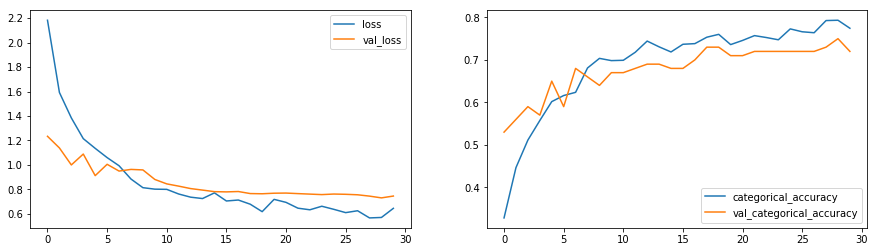

In [24]:
plot(history_model_11)

## **Model 12 - More Augmentation and Adding more layers - Similar to model 4**

In [25]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_22 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [29]:
print("Total Params:", conv_3d12_model.count_params())
history_model_12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 121s 4s/step - loss: 2.2360 - categorical_accuracy: 0.3102 - val_loss: 1.8256 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2021-01-2815_26_05.610256/model-00001-2.26140-0.30543-1.82561-0.39000.h5
Epoch 2/30
34/34 [==============================] - 100s 3s/step - loss: 1.6463 - categorical_accuracy: 0.4481 - val_loss: 1.1248 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2021-01-2815_26_05.610256/model-00002-1.62313-0.45098-1.12476-0.61000.h5
Epoch 3/30
34/34 [==============================] - 104s 3s/step - loss: 1.4538 - categorical_accuracy: 0.4915 - val_loss: 0.8926 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2021-01-2815_26_05.610256/model-00003-1.40828-0.50377-0.89257-0.69000.h5
Epoch 4/30
34/34 [==============================] - 105s 3s/step - loss: 1.2406 - categorical_accuracy: 0.5710 - val_loss: 1.8067 - val_categ

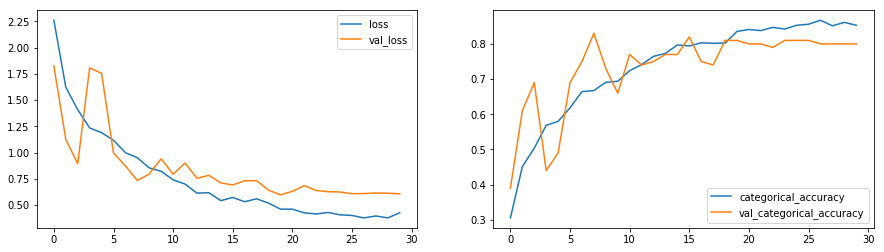

In [30]:
plot(history_model_12)

## **Model 13 - More Agumentation and Adding dropouts - Similar to Model 5**

In [31]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_30 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [33]:
print("Total Params:", conv_3d13_model.count_params())
history_model_13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 113s 3s/step - loss: 1.9025 - categorical_accuracy: 0.3366 - val_loss: 2.5438 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2021-01-2816_36_17.689037/model-00001-1.90952-0.33258-2.54382-0.29000.h5
Epoch 2/25
34/34 [==============================] - 99s 3s/step - loss: 1.6262 - categorical_accuracy: 0.4253 - val_loss: 3.1680 - val_categorical_accuracy: 0.3200

Epoch 00002: saving model to model_init_2021-01-2816_36_17.689037/model-00002-1.60036-0.42760-3.16799-0.32000.h5
Epoch 3/25
34/34 [==============================] - 104s 3s/step - loss: 1.3604 - categorical_accuracy: 0.4750 - val_loss: 3.4874 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_2021-01-2816_36_17.689037/model-00003-1.35507-0.48265-3.48736-0.33000.h5
Epoch 4/25
34/34 [==============================] - 104s 3s/step - loss: 1.2074 - categorical_accuracy: 0.5430 - val_loss: 3.1987 - val_catego

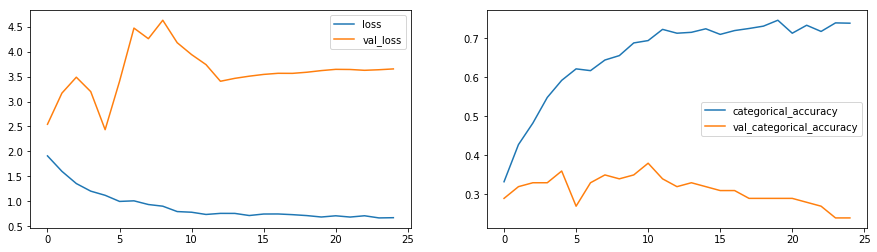

In [34]:
plot(history_model_13)

## **Model 14 - reducing network parameters - Similar to Model 6**

In [35]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_38 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 8, 50, 50, 32)     128       
__________

In [37]:
print("Total Params:", conv_3d14_model.count_params())
history_model_14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 92s 3s/step - loss: 1.8202 - categorical_accuracy: 0.3285 - val_loss: 1.2477 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2021-01-2817_24_53.393240/model-00001-1.82881-0.33258-1.24767-0.52000.h5
Epoch 2/30
34/34 [==============================] - 82s 2s/step - loss: 1.2198 - categorical_accuracy: 0.5239 - val_loss: 0.9979 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2021-01-2817_24_53.393240/model-00002-1.22364-0.52866-0.99789-0.60000.h5
Epoch 3/30
34/34 [==============================] - 86s 3s/step - loss: 0.9906 - categorical_accuracy: 0.6233 - val_loss: 0.9919 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2021-01-2817_24_53.393240/model-00003-1.00588-0.61388-0.99192-0.65000.h5
Epoch 4/30
34/34 [==============================] - 85s 2s/step - loss: 0.8510 - categorical_accuracy: 0.6729 - val_loss: 0.9267 - val_categorica

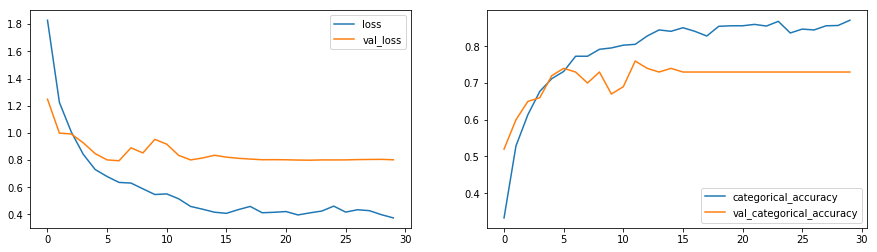

In [38]:
plot(history_model_14)

## **Model 15 - reducing network parameters - Similar to model 7**

In [39]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [40]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_41 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_42 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 8, 60, 60, 32)     128       
__________

In [41]:
print("Total Params:", conv_3d15_model.count_params())
history_model_15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 98s 3s/step - loss: 1.8278 - categorical_accuracy: 0.3396 - val_loss: 1.3299 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2021-01-2818_11_41.262620/model-00001-1.83122-0.33560-1.32986-0.54000.h5
Epoch 2/25
34/34 [==============================] - 89s 3s/step - loss: 1.3470 - categorical_accuracy: 0.4592 - val_loss: 1.1936 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2021-01-2818_11_41.262620/model-00002-1.34580-0.46229-1.19356-0.57000.h5
Epoch 3/25
34/34 [==============================] - 91s 3s/step - loss: 1.1803 - categorical_accuracy: 0.5486 - val_loss: 0.9107 - val_categorical_accuracy: 0.6800

Epoch 00003: saving model to model_init_2021-01-2818_11_41.262620/model-00003-1.13633-0.54977-0.91073-0.68000.h5
Epoch 4/25
34/34 [==============================] - 89s 3s/step - loss: 0.9711 - categorical_accuracy: 0.6096 - val_loss: 0.9164 - val_categorica

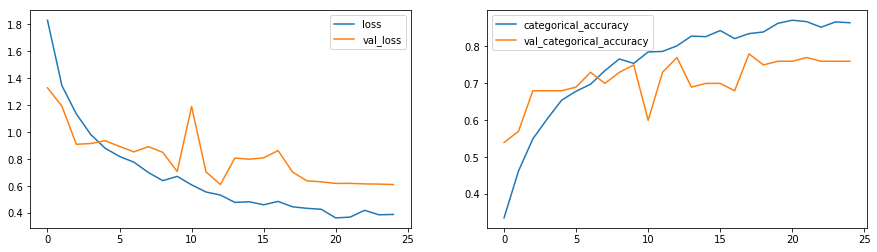

In [42]:
plot(history_model_15)

## **Model 16 - reducing network parameters - Similar to Model 8**

In [43]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_45 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_46 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 8, 60, 60, 16)     64        
__________

In [45]:
print("Total Params:", conv_3d16_model.count_params())
history_model_16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 97s 3s/step - loss: 2.0187 - categorical_accuracy: 0.2634 - val_loss: 1.4382 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2021-01-2818_51_18.535636/model-00001-2.01235-0.26998-1.43825-0.42000.h5
Epoch 2/30
34/34 [==============================] - 84s 2s/step - loss: 1.5972 - categorical_accuracy: 0.3767 - val_loss: 1.2483 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2021-01-2818_51_18.535636/model-00002-1.56722-0.38612-1.24827-0.49000.h5
Epoch 3/30
34/34 [==============================] - 88s 3s/step - loss: 1.3939 - categorical_accuracy: 0.4617 - val_loss: 1.2258 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2021-01-2818_51_18.535636/model-00003-1.39812-0.46078-1.22579-0.46000.h5
Epoch 4/30
34/34 [==============================] - 89s 3s/step - loss: 1.2635 - categorical_accuracy: 0.5088 - val_loss: 1.1038 - val_categorica

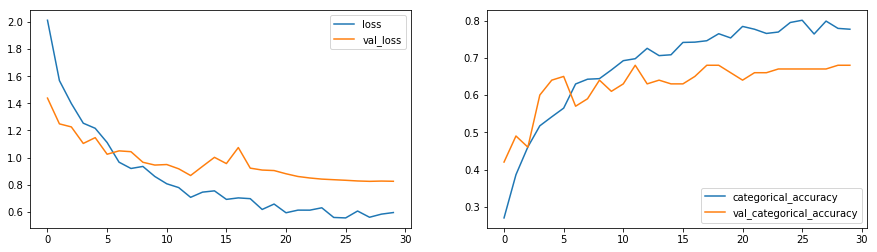

In [46]:
plot(history_model_16)

## **Model 17 - CNN LSTM with GRU - Similar to Model 9**

In [15]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [17]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model_17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 224s 7s/step - loss: 1.4668 - categorical_accuracy: 0.3790 - val_loss: 1.1810 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2021-01-2820_55_23.325400/model-00001-1.45987-0.38009-1.18103-0.54000.h5
Epoch 2/20
34/34 [==============================] - 125s 4s/step - loss: 1.1192 - categorical_accuracy: 0.5486 - val_loss: 0.9386 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2021-01-2820_55_23.325400/model-00002-1.11912-0.54977-0.93860-0.66000.h5
Epoch 3/20
34/34 [==============================] - 99s 3s/step - loss: 0.9108 - categorical_accuracy: 0.6479 - val_loss: 0.9221 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2021-01-2820_55_23.325400/model-00003-0.92040-0.64329-0.92206-0.63000.h5
Epoch 4/20
34/34 [==============================] - 98s 3s/step - loss: 0.7797 - categorical_accuracy: 0.7068 - val_loss: 0.8490 - val_categor

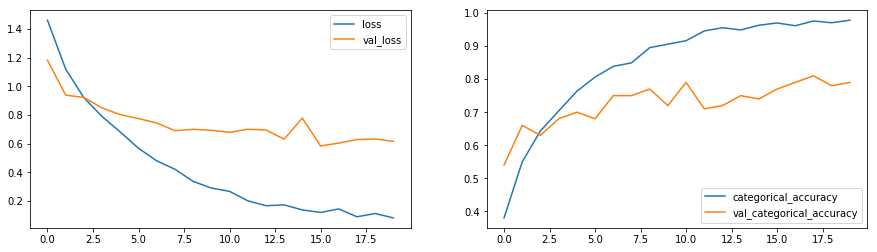

In [18]:
plot(history_model_17)

**We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy**

## **Model 18 - Transfer Learning**

In [19]:
from keras.applications import mobilenet

In [20]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 1s 0us/step


In [21]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
__________

In [22]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model_18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 144s 1s/step - loss: 1.5011 - categorical_accuracy: 0.3524 - val_loss: 1.3457 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2021-01-2821_31_57.286488/model-00001-1.50218-0.35143-1.34574-0.46000.h5
Epoch 2/20
133/133 [==============================] - 81s 608ms/step - loss: 1.1474 - categorical_accuracy: 0.5263 - val_loss: 1.3291 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2021-01-2821_31_57.286488/model-00002-1.14704-0.52640-1.32914-0.45000.h5
Epoch 3/20
133/133 [==============================] - 84s 630ms/step - loss: 1.0427 - categorical_accuracy: 0.5827 - val_loss: 1.1167 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2021-01-2821_31_57.286488/model-00003-1.04192-0.58296-1.11670-0.54000.h5
Epoch 4/20
133/133 [==============================] - 82s 616ms/step - loss: 0.9033 - categorical_accuracy: 0.6622 - val_loss: 1.09

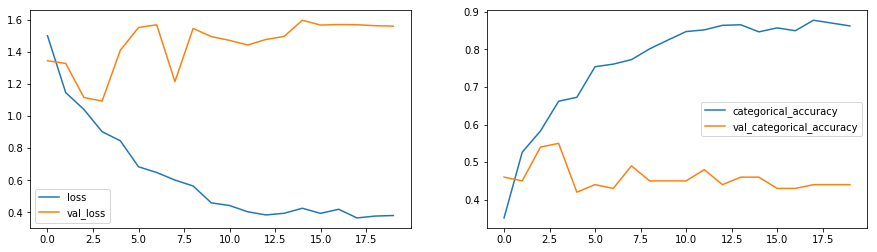

In [23]:
plot(history_model_18)

**We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement**

## **Model - 19 - Transfer Learning with GRU and training all weights**

In [24]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
__________

In [27]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model_19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3692869
Epoch 1/20
133/133 [==============================] - 99s 744ms/step - loss: 0.0182 - categorical_accuracy: 0.9962 - val_loss: 0.1477 - val_categorical_accuracy: 0.9400

Epoch 00001: saving model to model_init_2021-01-2822_28_41.765921/model-00001-0.01826-0.99623-0.14767-0.94000.h5
Epoch 2/20
133/133 [==============================] - 94s 706ms/step - loss: 0.0199 - categorical_accuracy: 0.9947 - val_loss: 0.1621 - val_categorical_accuracy: 0.9500

Epoch 00002: saving model to model_init_2021-01-2822_28_41.765921/model-00002-0.01997-0.99472-0.16211-0.95000.h5
Epoch 3/20
133/133 [==============================] - 93s 703ms/step - loss: 0.0161 - categorical_accuracy: 0.9955 - val_loss: 0.1369 - val_categorical_accuracy: 0.9400

Epoch 00003: saving model to model_init_2021-01-2822_28_41.765921/model-00003-0.01611-0.99548-0.13686-0.94000.h5
Epoch 4/20
133/133 [==============================] - 94s 710ms/step - loss: 0.0202 - categorical_accuracy: 0.9955 - val_loss: 0.

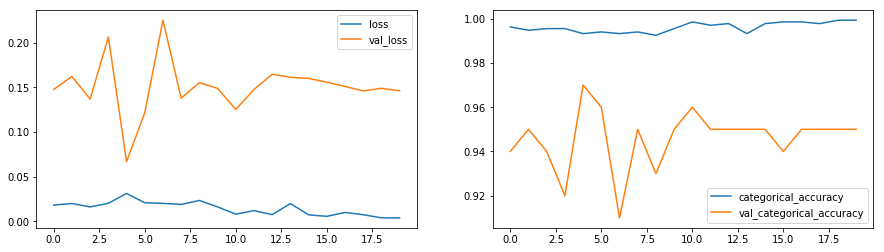

In [28]:
plot(history_model_19)

## The accuracy results from the above model are 99% for training accuracy and 96% for validation accuracy

## Consolidated Final Models

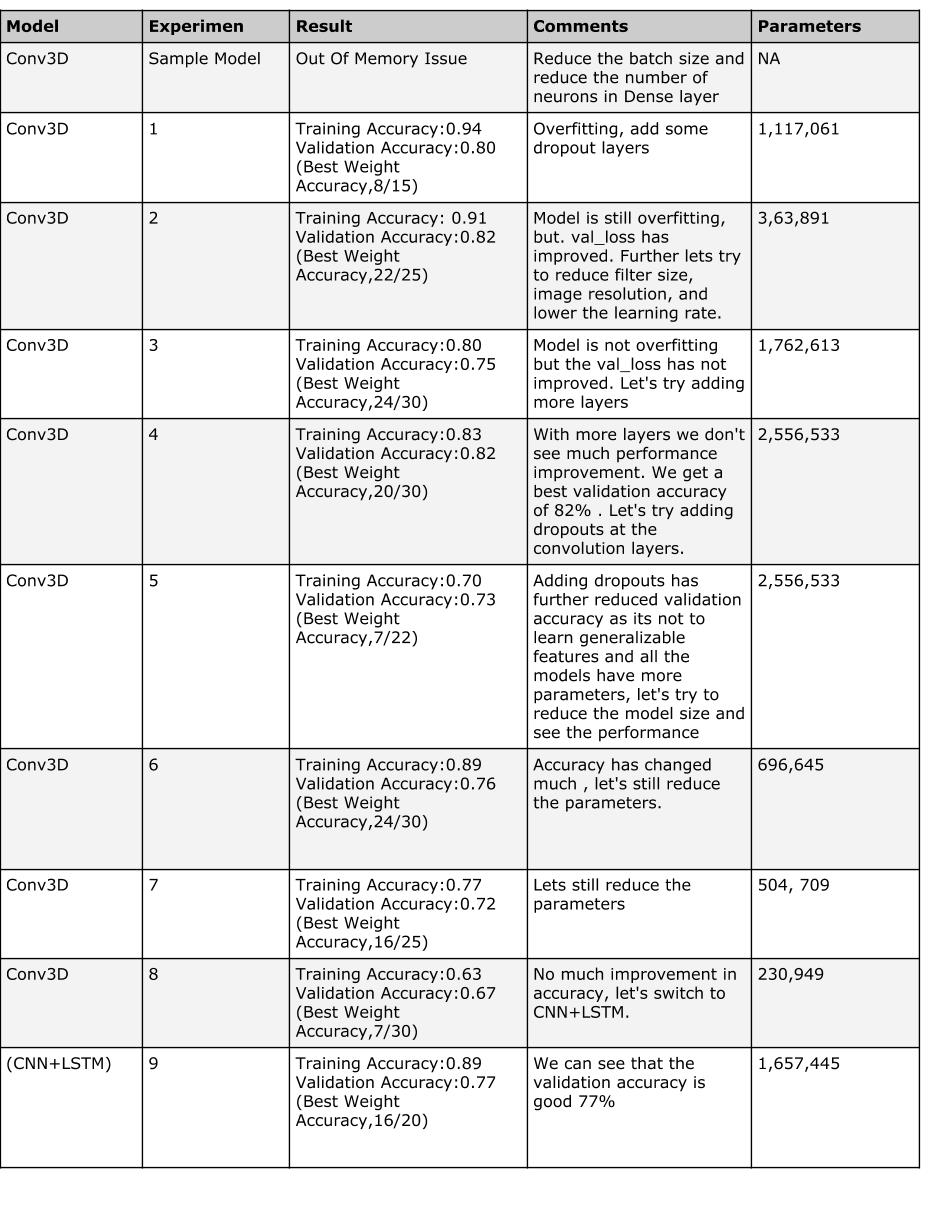

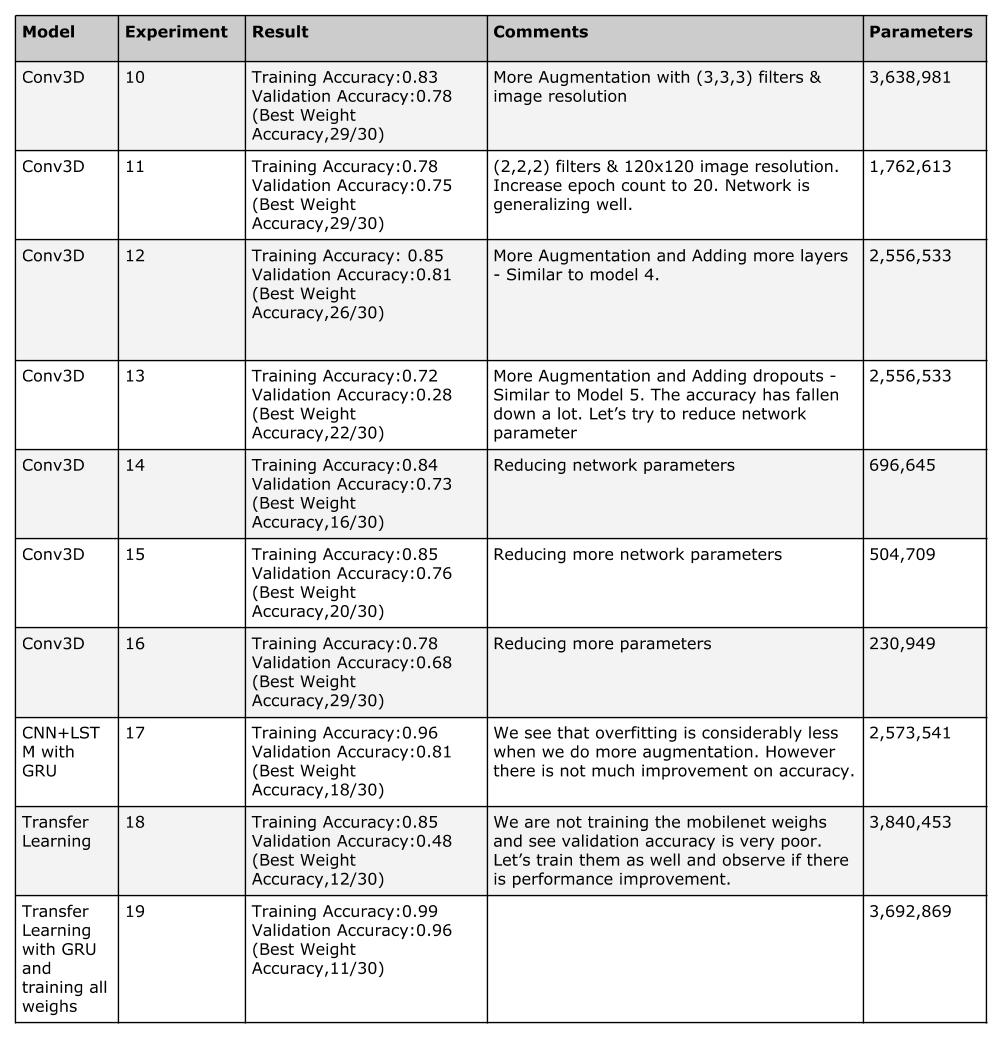

### After doing all the experiments, we finalized Model 9–CNN+LSTM, which performed well.

#### Reason:

* Training Accuracy: 89%, Validation Accuracy: 77%
* Number of Parameters (1,657,445) less according to other models’ performances.
* Learning rate gradually decreasing after some Epochs

**The best weights of CNN-LSTM: model-00016-0.25427-0.90347-0.58490-0.77000.h5 (19.0 MB). we considered this weight for model testing, Let's have look at the performance below**


## **Loading model and Testing**

In [23]:
import time
from keras.models import load_model
model = load_model('model-00016-0.25427-0.90347-0.58490-0.77000.h5')

In [24]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [25]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [26]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[3 0 0 3 3 0 4 2 0 4 4 3 2 3 4 0 1 4 3 1]
